In [1]:
%matplotlib inline


# Cálculo de las curvas IV de un módulo fotovoltaico.


Ejemplos de modelado de curvas IV utilizando un modelo equivalente de circuito de diodo único.


El cálculo de la curva IV de un módulo para determinadas condiciones de funcionamiento es un proceso de dos pasos
dos pasos.  Existen múltiples métodos para ambas partes del proceso.  Aquí utilizamos el modelo de De Soto [1]_ para calcular los parámetros eléctricos de una curva IV a una irradiancia y temperatura determinadas utilizando las características del módulo en condiciones de referencia.  Estos parámetros se utilizan para calcular la curva IV del módulo resolviendo la ecuación del diodo único por el método de método de Lambert W.


La ecuación de diodo único es un modelo de circuito equivalente de una célula fotovoltaica, tiene cinco parámetros eléctricos que dependen de las condiciones de funcionamiento de funcionamiento.  Para más detalles sobre la ecuación de diodo único y los cinco parámetros, consulte la siguiente pagina: [PVPMC single diode page](https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/diode-equivalent-circuit-models/).

## Referencias
 .. [1] W. De Soto et al., "Improvement and validation of a model for
    photovoltaic array performance", Solar Energy, vol 80, pp. 78-88, 2006.

## Calculando las curvas IV
This example uses :py:meth:`pvlib.pvsystem.calcparams_desoto` to calculate
the 5 electrical parameters needed to solve the single-diode equation.
:py:meth:`pvlib.pvsystem.singlediode` is then used to generate the IV curves.



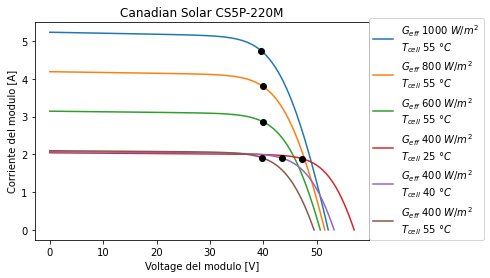

       i_sc       v_oc      i_mp       v_mp        p_mp
0  5.235561  52.129783  4.742475  39.614016  187.868473
1  4.190781  51.483033  3.805721  39.867812  151.725757
2  3.144837  50.649228  2.861983  39.956701  114.355380
3  2.043319  56.987478  1.886789  47.278408   89.204377
4  2.070523  53.238567  1.901044  43.490203   82.676791
5  2.097727  49.474044  1.912108  39.735026   75.977656


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


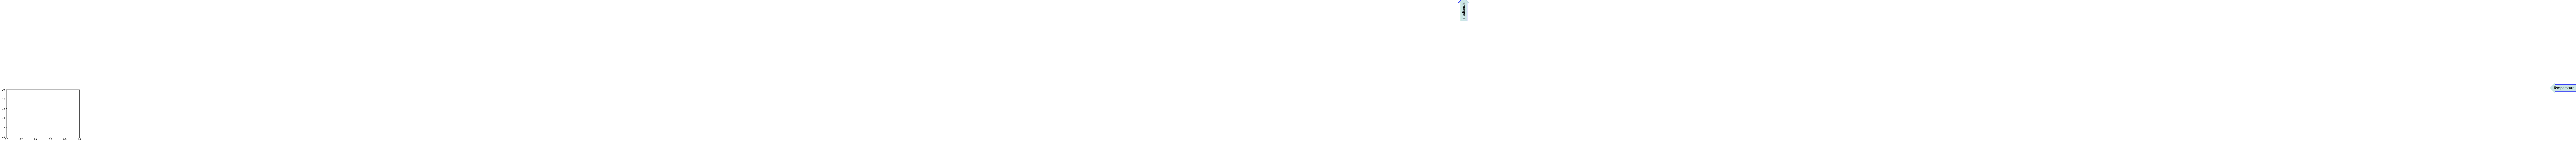

In [7]:
from pvlib import pvsystem
import pandas as pd
import matplotlib.pyplot as plt

# Example module parameters for the Canadian Solar CS5P-220M:
parameters = {
    'Name': 'Canadian Solar CS5P-220M',
    'BIPV': 'N',
    'Date': '10/5/2009',
    'T_NOCT': 42.4,
    'A_c': 1.7,
    'N_s': 96,
    'I_sc_ref': 5.1,
    'V_oc_ref': 59.4,
    'I_mp_ref': 4.69,
    'V_mp_ref': 46.9,
    'alpha_sc': 0.004539,
    'beta_oc': -0.22216,
    'a_ref': 2.6373,
    'I_L_ref': 5.114,
    'I_o_ref': 8.196e-10,
    'R_s': 1.065,
    'R_sh_ref': 381.68,
    'Adjust': 8.7,
    'gamma_r': -0.476,
    'Version': 'MM106',
    'PTC': 200.1,
    'Technology': 'Mono-c-Si',
}

cases = [
    (1000, 55),
    (800, 55),
    (600, 55),
    (400, 25),
    (400, 40),
    (400, 55)
]

conditions = pd.DataFrame(cases, columns=['Geff', 'Tcell'])

# Ajusta los parámetros de referencia según las condiciones
# condiciones de funcionamiento utilizando el modelo De Soto:
IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
    conditions['Geff'],
    conditions['Tcell'],
    alpha_sc=parameters['alpha_sc'],
    a_ref=parameters['a_ref'],
    I_L_ref=parameters['I_L_ref'],
    I_o_ref=parameters['I_o_ref'],
    R_sh_ref=parameters['R_sh_ref'],
    R_s=parameters['R_s'],
    EgRef=1.121,
    dEgdT=-0.0002677
)

# Introduce los parámetros en la SDE y resuelve las curvas IV:
curve_info = pvsystem.singlediode(
    photocurrent=IL,
    saturation_current=I0,
    resistance_series=Rs,
    resistance_shunt=Rsh,
    nNsVth=nNsVth,
    ivcurve_pnts=100,
    method='lambertw'
)

# Grafica las curvas calculadas:
plt.figure()
for i, case in conditions.iterrows():
    label = (
        "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
        "$T_{cell}$ " + f"{case['Tcell']} $\\degree C$"
    )
    plt.plot(curve_info['v'][i], curve_info['i'][i], label=label)
    v_mp = curve_info['v_mp'][i]
    i_mp = curve_info['i_mp'][i]
    # Ponle una marca o al Punto de Maxima Potencia.
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.legend(loc=(1.0, 0))
plt.xlabel('Voltage del modulo [V]')
plt.ylabel('Corriente del modulo [A]')
plt.title(parameters['Name'])
plt.show()
plt.gcf().set_tight_layout(True)


# Esta funcion dibuja las flechas de tendencia
def draw_arrow(ax, label, x0, y0, rotation, size, direction):
    style = direction + 'arrow'
    bbox_props = dict(boxstyle=style, fc=(0.8, 0.9, 0.9), ec="b", lw=1)
    t = ax.text(x0, y0, label, ha="left", va="bottom", rotation=rotation,
                size=size, bbox=bbox_props, zorder=-1)

    bb = t.get_bbox_patch()
    bb.set_boxstyle(style, pad=0.6)


ax = plt.gca()
draw_arrow(ax, 'Irradiancia', 20, 2.5, 90, 15, 'r')
draw_arrow(ax, 'Temperatura', 35, 1, 0, 15, 'l')

print(pd.DataFrame({
    'i_sc': curve_info['i_sc'],
    'v_oc': curve_info['v_oc'],
    'i_mp': curve_info['i_mp'],
    'v_mp': curve_info['v_mp'],
    'p_mp': curve_info['p_mp'],
}))

In [9]:
print(conditions.head())

   Geff  Tcell
0  1000     55
1   800     55
2   600     55
3   400     25
4   400     40
